<a href="https://colab.research.google.com/github/carolyn-wang/Flixster/blob/master/cs180_proj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CS194-26 (CS294-26): Project 1 starter Python code

# these are just some suggested libraries
# instead of scikit-image you could use matplotlib and opencv to read, write, and display images

import numpy as np
import skimage as sk
import skimage.io as skio
import sys


In [ ]:
# name of the input file
imname = 'monastery.jpg'

In [ ]:
# read in the image
im = skio.imread(imname)

# convert to double (might want to do this later on to save memory)
im = sk.img_as_float(im)

# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

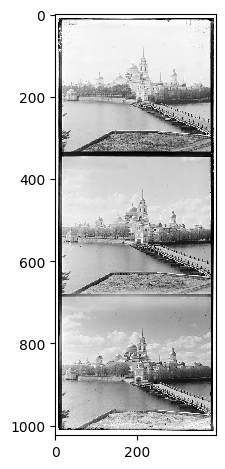

In [ ]:
skio.imshow(im)
skio.show()

The easiest way to align the parts is to exhaustively search over a window of possible displacements (say [-15,15] pixels), score each one using some image matching metric, and take the displacement with the best score. There is a number of possible metrics that one could use to score how well the images match. The simplest one is just the L2 norm also known as the Sum of Squared Differences (SSD) distance which is simply sum(sum((image1-image2).^2)) where the sum is taken over the pixel values. Another is normalized cross-correlation (NCC), which is simply a dot product between two normalized vectors: (image1./||image1|| and image2./||image2||). Note that in the case of the Emir of Bukhara (show on right), the images to be matched do not actually have the same brightness values (they are different color channels), so you might have to use a cleverer metric, or different features than the raw pixels.

Your job will be to implement an algorithm that, given a 3-channel image, produces a color image as output. Implement a simple single-scale version first, using for loops, searching over a user-specified window of displacements. The above directory has skeleton Python/MATLAB code that will help you get started and you should pick one of the smaller .jpg images in the directory to test this version of the code. Next, add a coarse-to-fine pyramid speedup to handle large images like the .tiff ones provided in the directory.

# Align Colors (naive implementation)

In [ ]:
# align the images
# functions that might be useful for aligning the images include:
# np.roll, np.sum, sk.transform.rescale (for multiscale)
def align(image1, image2):
  best_image = image1
  best_x_shift = 0
  best_y_shift = 0
  lowest_diff = sys.maxsize
  for x_shift in range(-15, 15):
    for y_shift in range(-15, 15):
      tform = sk.transform.AffineTransform(translation=(x_shift, y_shift))
      image1_translated = sk.transform.warp(image1, inverse_map=tform.inverse)
      diff = ssd(image1_translated, image2)
      if diff < lowest_diff:
        best_image = image1_translated
        best_x_shift = x_shift
        best_y_shift = y_shift
        lowest_diff = diff
  return best_image, best_x_shift, best_y_shift

def ssd(im1, im2):
  return sum(sum((im1-im2)**2))

def ncc(im1, im2):
  im1 = im1.flatten()
  im2 = im2.flatten()
  return np.dot(im1/np.linalg.norm(im1) , im2/np.linalg.norm(im2))

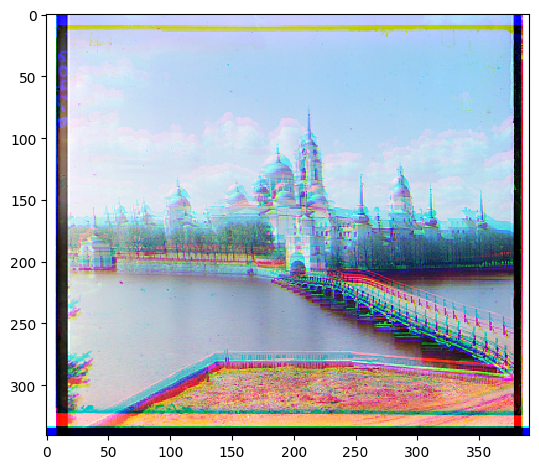

In [ ]:
ag,_,_ = align(g, b)
ar,_,_ = align(r, b)
# create a color image
im_out = np.dstack([ar, ag, b])

# # save the image
# fname = 'combined_image'
# skio.imsave(fname, im_out)

# display the image
skio.imshow(im_out)
skio.show()

# Image Pyramid


Exhaustive search will become prohibitively expensive if the pixel displacement is too large (which will be the case for high-resolution glass plate scans). In this case, you will need to implement a faster search procedure such as an image pyramid. An image pyramid represents the image at multiple scales (usually scaled by a factor of 2) and the processing is done sequentially starting from the coarsest scale (smallest image) and going down the pyramid, updating your estimate as you go. It is very easy to implement by adding recursive calls to your original single-scale implementation. Do not use MATLAB's impyramid function but you can use imresize.

In [ ]:
def rescale_im(b,g,r, scale = 1):
  b = sk.transform.rescale(b, scale, anti_aliasing=False)
  g = sk.transform.rescale(g, scale, anti_aliasing=False)
  r = sk.transform.rescale(r, scale, anti_aliasing=False)
  return b,g,r

In [ ]:
def align_scaled(g,b,r,prev_ag_x, prev_ag_y, prev_ar_x, prev_ar_y, scale = 1.0):
  b,g,r = rescale_im(b,g,r, scale = scale)

  g_tform = sk.transform.AffineTransform(translation=(prev_ag_x * 2, prev_ag_y * 2))
  g_translated = sk.transform.warp(g, inverse_map=g_tform.inverse)

  r_tform = sk.transform.AffineTransform(translation=(prev_ar_x * 2, prev_ar_y * 2))
  r_translated = sk.transform.warp(r, inverse_map=r_tform.inverse)

  ag, ag_x, ag_y = align(g_translated, b)
  ar, ar_x, ar_y = align(r_translated, b)
  # create a color image
  im_out = np.dstack([ar, ag, b])

  # # save the image
  # fname = 'combined_image'
  # skio.imsave(fname, im_out)

  # display the image
  skio.imshow(im_out)
  skio.show()

  return (prev_ag_x * 2) + ag_x, (prev_ag_y * 2) + ag_y, (prev_ar_x * 2) + ar_x, (prev_ar_y * 2) + ar_y

In [ ]:
# read in the image
im_harvesters = skio.imread('harvesters.tif')

# convert to double (might want to do this later on to save memory)
im_harvesters = sk.img_as_float(im_harvesters)

# compute the height of each part (just 1/3 of total)
height = np.floor(im_harvesters.shape[0] / 3.0).astype(int)

# separate color channels
b_im_harvesters = im_harvesters[:height]
g_im_harvesters = im_harvesters[height: 2*height]
r_im_harvesters = im_harvesters[2*height: 3*height]

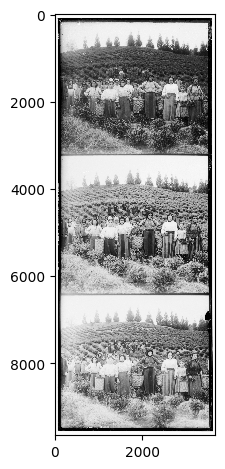

In [ ]:
skio.imshow(im_harvesters)
skio.show()

In [ ]:
def run_image_pyramid(g,b,r, num_iters = 5):
  ag_x, ag_y, ar_x, ar_y = 0,0,0,0
  for i in range(num_iters,-1,-1):
    scale = 1 / (2**i)
    ag_x, ag_y, ar_x, ar_y = align_scaled(g,b,r,ag_x, ag_y, ar_x, ar_y,scale=scale)
    print(ag_x, ag_y, ar_x, ar_y)
    scale = scale / 2
  return

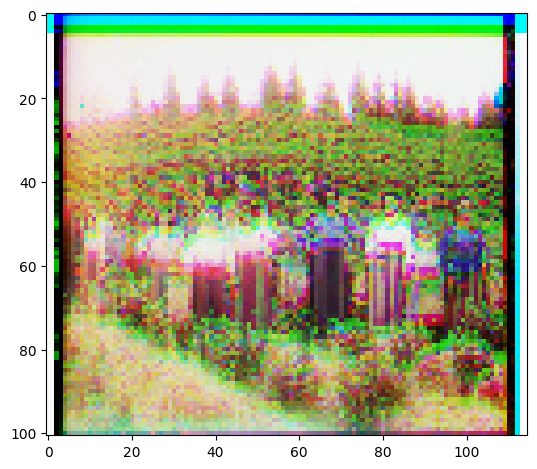

0 0 0 5


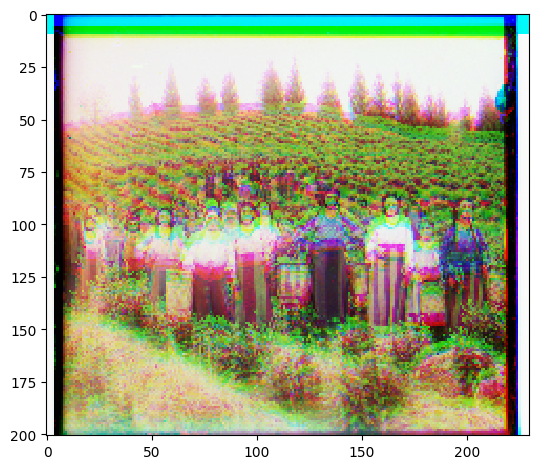

0 0 0 10


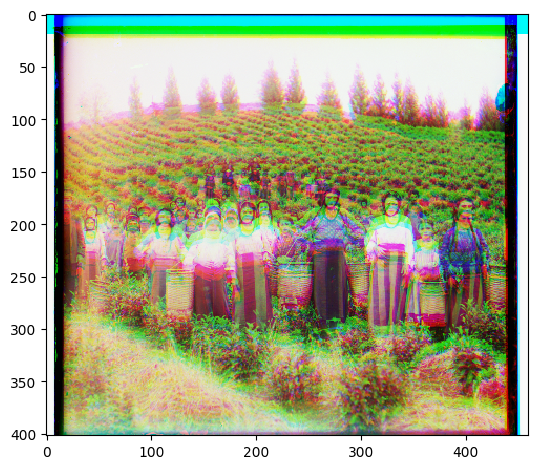

0 0 0 20


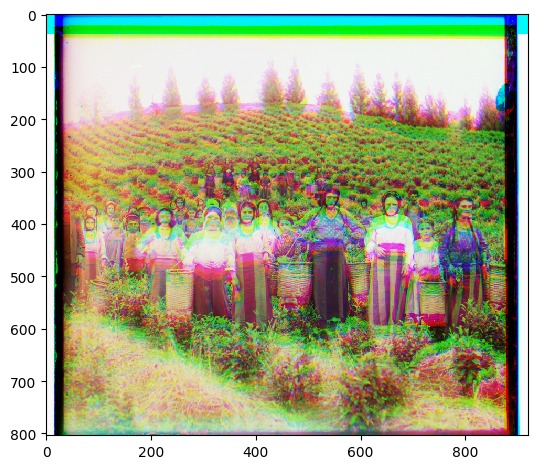

0 0 0 40


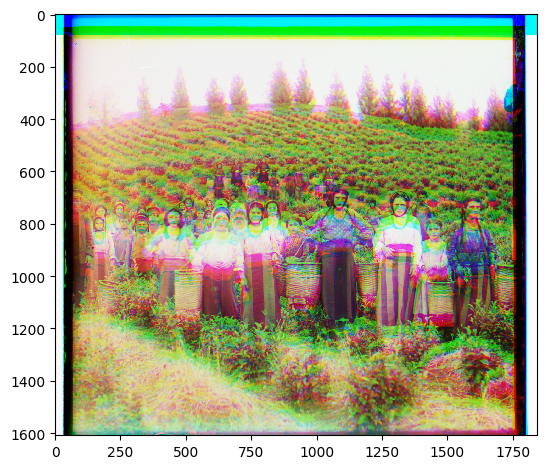

0 0 0 80


KeyboardInterrupt: ignored

In [ ]:
run_image_pyramid(g_im_harvesters,b_im_harvesters,r_im_harvesters)

# Align Colors (removed borders)

In [ ]:
# find index of first non-1 pixel
# white: 1, black: 0

def detect_edge(image, edge = 'left'):
  if edge == "top" or edge == "bottom":
    image = image.T
  third_height = np.floor(image.shape[0] / 3.0).astype(int)
  quarter_width = np.floor(image.shape[1] / 4.0).astype(int)

  max_diff = 100
  edge_ind = 123
  window_width = 5

  window_height_start = third_height + 40
  window_height_end = third_height * 2 - 40
  if edge == 'right' or edge == "bottom":
    scanning_window = range(image.shape[1] - window_width, image.shape[1] - quarter_width, -1)
  else:
    scanning_window = range(window_width, quarter_width)

  for i in scanning_window:
    left_col = image[window_height_start : window_height_end, i-window_width : i]
    right_col = image[window_height_start: window_height_end, i: i + window_width]

    diff = np.mean(left_col) - np.mean(right_col) # change from black border to white border (left - right as small/negative as possible)
    if edge == 'right' or edge == "bottom":
      diff = np.mean(right_col) - np.mean(left_col)
    if diff < max_diff:
      max_diff = diff
      edge_ind = i
  return edge_ind


In [ ]:
def remove_border(im):
  left_edge = detect_edge(im, edge ='left')
  right_edge = detect_edge(im, edge = 'right')
  top_edge = detect_edge(im, edge ='top')
  bottom_edge = detect_edge(im, edge = 'bottom')

  print(left_edge, right_edge, top_edge, bottom_edge)

  im_no_border = im[top_edge: bottom_edge, left_edge:right_edge]
  return im_no_border

In [ ]:
# read in the image
im = skio.imread(imname)
im = sk.img_as_float(im)

im_no_border = remove_border(im)

# compute the height of each part (just 1/3 of total)
height = np.floor(im_no_border.shape[0] / 3.0).astype(int)

# separate color channels
b = im_no_border[:height]
g = im_no_border[height: 2*height]
r = im_no_border[2*height: 3*height]


18 378 15 1008


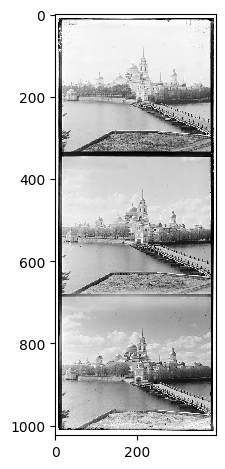

In [ ]:
skio.imshow(im)
skio.show()

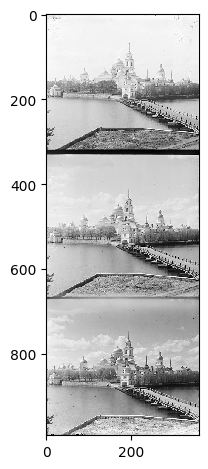

In [ ]:
skio.imshow(im_no_border)
skio.show()

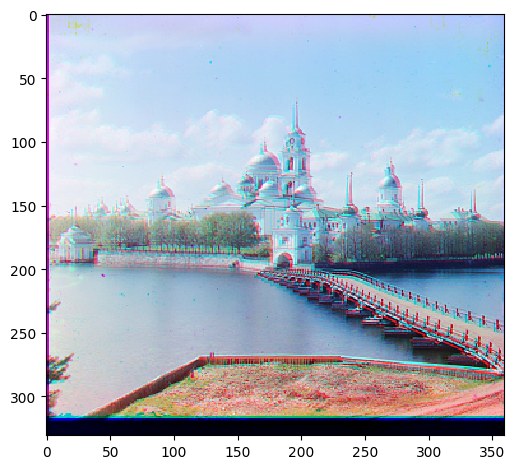

In [ ]:
ag,_,_ = align(g, b)
ar,_,_ = align(r, b)
# create a color image
im_out = np.dstack([ar, ag, b])

# # save the image
# fname = 'combined_image'
# skio.imsave(fname, im_out)

# display the image
skio.imshow(im_out)
skio.show()

In [ ]:
im_harvesters_no_border = remove_border(im_harvesters)

# compute the height of each part (just 1/3 of total)
height = np.floor(im_harvesters_no_border.shape[0] / 3.0).astype(int)

# separate color channels
b = im_harvesters_no_border[:height]
g = im_harvesters_no_border[height: 2*height]
r = im_harvesters_no_border[2*height: 3*height]

135 3499 193 9496


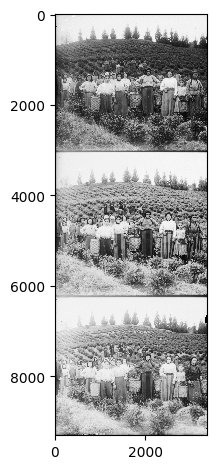

In [ ]:
skio.imshow(im_harvesters_no_border)
skio.show()

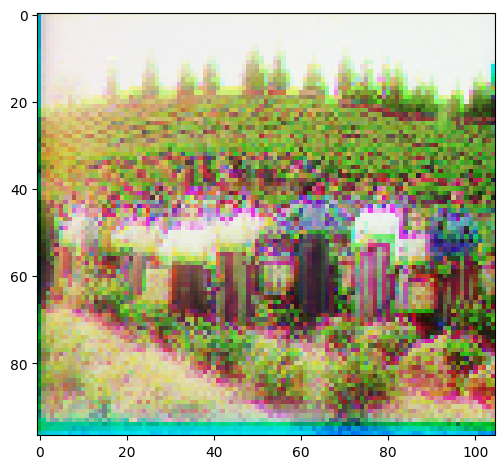

0 0 1 -3


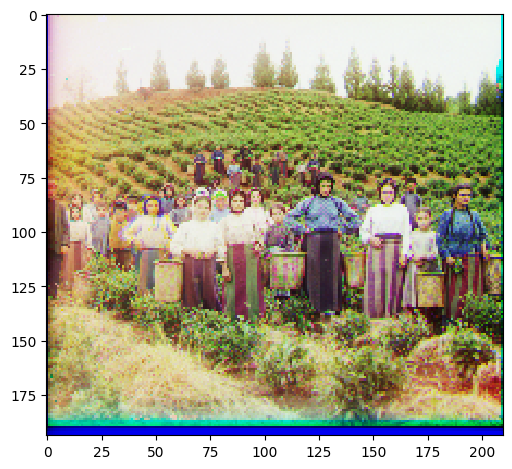

1 -4 1 -7


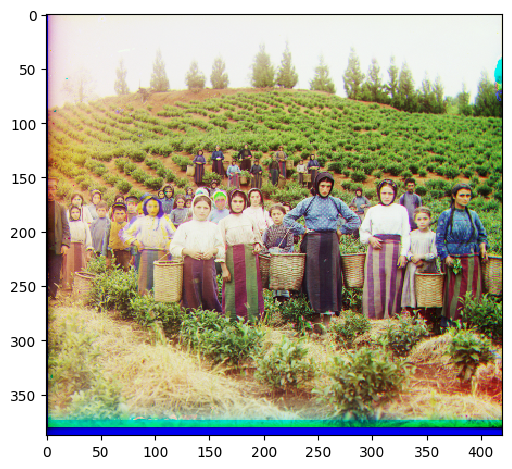

2 -7 2 -14


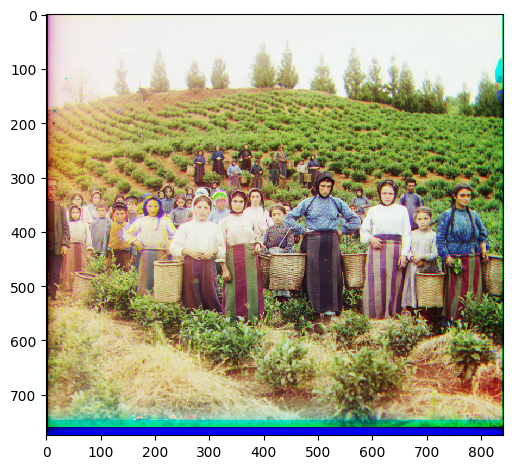

4 -14 3 -28


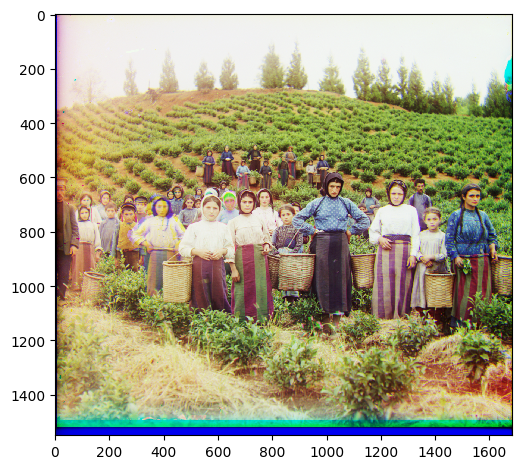

8 -29 7 -55


KeyboardInterrupt: ignored

In [ ]:
run_image_pyramid(g,b,r)